# RQ2b: What is the effect of prevalence shifts on the quality of decision rules
This notebook generates the figures 3, 7 and 8. It shows qualitatively the implications of prevalence shifts on optimal thresholds in our use cases.

In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath('..'))
from pathlib import Path

import numpy as np
import torch
from progiter import ProgIter
import matplotlib.pyplot as plt
from PIL import Image
from pdf2image import convert_from_path

from src.prev.calibration import CalibrationMethod, calibrate_logits_fast
from src.prev.data_loading import get_values, Kind, Split, all_tasks, task_name_map
from src.prev.plotting import get_calibration_color, get_metric_color
from src.prev.scaling import scale_prevalences_ir, imbalance_ratio
from src.prev.utils import Metric
from src.prev.thresholding import find_best_thresholds

plt.style.use('seaborn')

current_path = os.getcwd()
DATA_PATH = Path(current_path).parent / 'data'
RESULT_PATH = Path(current_path).parent / 'results'
assert DATA_PATH.exists() and RESULT_PATH.exists()
torch.manual_seed(seed=0)

from matplotlib import font_manager

font_path = DATA_PATH / 'NewCM10-Regular.otf'
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NewComputerModern10'

/tmp/ipykernel_1742172/664353401.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
data = {}
for t in ProgIter(all_tasks, desc='Loading data'):
    data[t] = get_values(t, DATA_PATH, proj='mic23_predictions_original_0')  # original paper predictions

Loading data 100.00% 30/30... rate=3.23 Hz, eta=0:00:00, total=0:00:09


In [3]:
def get_all_logits_and_thresholds(task, ir=10, thresholds=False, scale=True):
    task_data = data[task]
    calibration = CalibrationMethod.AFFINE_REWEIGHTED
    original_logits = task_data[Kind.LOGITS][Split.DEV_TEST]
    original_labels = task_data[Kind.LABELS][Split.DEV_TEST]
    if scale:
        app_test_logits, app_test_classes = scale_prevalences_ir(logits=task_data[Kind.LOGITS][Split.APP_TEST],
                                                                 classes=task_data[Kind.LABELS][Split.APP_TEST],
                                                                 ir=ir)
    else:
        app_test_logits, app_test_classes = task_data[Kind.LOGITS][Split.APP_TEST], task_data[Kind.LABELS][
            Split.APP_TEST]  #original_logits, original_labels
    mod_data = {Kind.LOGITS: {Split.DEV_CAL: task_data[Kind.LOGITS][Split.DEV_CAL],
                              Split.DEV_TEST: task_data[Kind.LOGITS][Split.DEV_TEST],
                              Split.APP_TEST: app_test_logits},
                Kind.LABELS: {Split.DEV_CAL: task_data[Kind.LABELS][Split.DEV_CAL],
                              Split.DEV_TEST: task_data[Kind.LABELS][Split.DEV_TEST],
                              Split.APP_TEST: app_test_classes}}
    prior = torch.bincount(mod_data[Kind.LABELS][Split.APP_TEST]) / len(mod_data[Kind.LABELS][Split.APP_TEST])
    affine_logits = calibrate_logits_fast(data=mod_data,
                                          calibration=calibration,
                                          prior=prior)
    temp_scal_logits = calibrate_logits_fast(data=mod_data,
                                             calibration=CalibrationMethod.TEMPERATURE_SCALING_REWEIGHTED,
                                             prior=prior)
    original_thresholds = {}
    app_test_thresholds = {}
    affine_thresholds = {}
    if thresholds & (original_logits.shape[1] == 2):
        val_prevalences = torch.bincount(mod_data[Kind.LABELS][Split.DEV_CAL])
        # compute minimal and maximal class of the dev cal set
        min_class = torch.argmin(val_prevalences).item()
        max_class = torch.argmax(val_prevalences).item()
        #catches case where for balanced task, min class was used as max class in scaling
        if min_class == max_class:
            min_class = 1
        exact_prevalence = torch.bincount(app_test_classes) / len(app_test_classes)
        original_thresholds = find_best_thresholds(labels=original_labels,
                                                   logits=original_logits, min_class=min_class,
                                                   priors=exact_prevalence.numpy())
        affine_thresholds = find_best_thresholds(labels=app_test_classes,
                                                 logits=affine_logits[Split.APP_TEST], min_class=min_class,
                                                 priors=exact_prevalence.numpy())
        app_test_thresholds = find_best_thresholds(labels=app_test_classes,
                                                   logits=app_test_logits, min_class=min_class,
                                                   priors=exact_prevalence.numpy())

    affine_logits = affine_logits[Split.APP_TEST]
    temp_scal_logits = temp_scal_logits[Split.APP_TEST]
    affine_logits = torch.softmax(affine_logits, dim=1)
    temp_scal_logits = torch.softmax(temp_scal_logits, dim=1)
    app_test_logits = torch.softmax(app_test_logits, dim=1)
    original_logits = torch.softmax(original_logits, dim=1)
    return {
        "original_logits": original_logits,
        "app_test_logits": app_test_logits,
        "affine_logits": affine_logits,
        "temp_scal_logits": temp_scal_logits,
        "original_labels": original_labels,
        "app_test_classes": app_test_classes,
        "original_thresholds": original_thresholds,
        "app_test_thresholds": app_test_thresholds,
        "affine_thresholds": affine_thresholds
    }

# Generate Figure 3

In [4]:
def plot_logits_bar(ax, logits, title, color='blue', add_legend=False):
    num_classes = logits.shape[0]
    x = np.arange(num_classes)
    ax.bar(x, logits, align='center', alpha=0.7, color=color)
    ax.set_xticks(x)
    ax.set_xticklabels(['Negative', 'Positive'])
    ax.set_title(title, fontsize=20)
    ax.set_ylim(0, 1)
    # Set the major ticks with the desired labels
    ax.set_yticks([0, 0.5, 1.0])
    ax.set_yticks([0.25, 0.75], minor=True)

    ax.grid(which='both')
    if num_classes == 2:
        line = ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=1)


def create_visualization(sample_idx, temp_scal_logits, affine_logits, app_test_logits, app_test_classes,
                         file_path=DATA_PATH / 'identity graph.pdf'):
    # Load the image
    img = convert_from_path(file_path, dpi=1000)
    img = np.array(img[0])

    # Create the figure and axes
    fig = plt.figure(figsize=(10, 8))
    gs = fig.add_gridspec(2, 3, height_ratios=[2, 1], hspace=0.0)

    # Add image subplot
    ax_img = fig.add_subplot(gs[0, :])
    ax_img.imshow(img)
    ax_img.axis('off')

    # Add bar plot subplots
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[1, 1])
    ax3 = fig.add_subplot(gs[1, 2])

    # Create bar plots
    plot_logits_bar(ax1, app_test_logits[sample_idx], 'No re-calibration',
                    color=[t / 255 for t in get_calibration_color(CalibrationMethod.NONE)])
    plot_logits_bar(ax2, temp_scal_logits[sample_idx], 'TempScal (dep. prev.)',
                    color=[t / 255 for t in get_calibration_color(CalibrationMethod.TEMPERATURE_SCALING_REWEIGHTED)])
    plot_logits_bar(ax3, affine_logits[sample_idx], 'Affine (dep. prev.)',
                    color=[t / 255 for t in get_calibration_color(CalibrationMethod.AFFINE_REWEIGHTED)],
                    add_legend=True)

    # Add text and arrow annotations
    fig.text(0.505, 0.25, "Class score ranking\nis preserved",
             ha='center', va='bottom', fontsize=14, color='red')
    fig.text(0.87, 0.30, "Bias term can change\nthe class score ranking",
             ha='center', va='bottom', fontsize=14, color='green')
    arrow = plt.Arrow(0.3, 0.23, 0.31, 0, width=0.05, color='black', alpha=0.5)
    fig.add_artist(arrow)
    arrow = plt.Arrow(0.88, 0.29, -0.10, -0.074, width=0.05, color='black', alpha=0.5)
    fig.add_artist(arrow)

    ax1.set_ylabel('Predicted class scores\nfor a single image', fontsize=20)

    # Adjust layout and display the plot
    plt.tight_layout(h_pad=0)
    return fig


In [15]:
def view_logit_visualisation(sample_idx: int, task_index: int):
    """Generates Figure 3, showing an example model logits for an image where Affine re-calibration changed the class ranking"""
    results = get_all_logits_and_thresholds(all_tasks[task_index], thresholds=False, scale=False)

    # identify indices where affine re-calibration changes the argmax prediction for the correct one for visualization
    changed_preds = (torch.argmax(results['app_test_logits'], dim=1) != torch.argmax(results['affine_logits'],
                                                                                     dim=1)) & (
                                torch.torch.argmax(results['app_test_logits'], dim=1) == results['app_test_classes'])
    if changed_preds.shape == torch.Size([]):
        print("No predictions changed")
        return
    app_test_logits = results['app_test_logits'][changed_preds]
    affine_logits = results['affine_logits'][changed_preds]
    temp_scal_logits = results['temp_scal_logits'][changed_preds]
    app_test_classes = results['app_test_classes'][changed_preds]

    # print the original index of the displayed image - we used this to retrieve the exact image for the figure
    # print(torch.where(changed_preds)[0][sample_idx])

    fig = create_visualization(sample_idx, temp_scal_logits, affine_logits, app_test_logits, app_test_classes)
    return fig

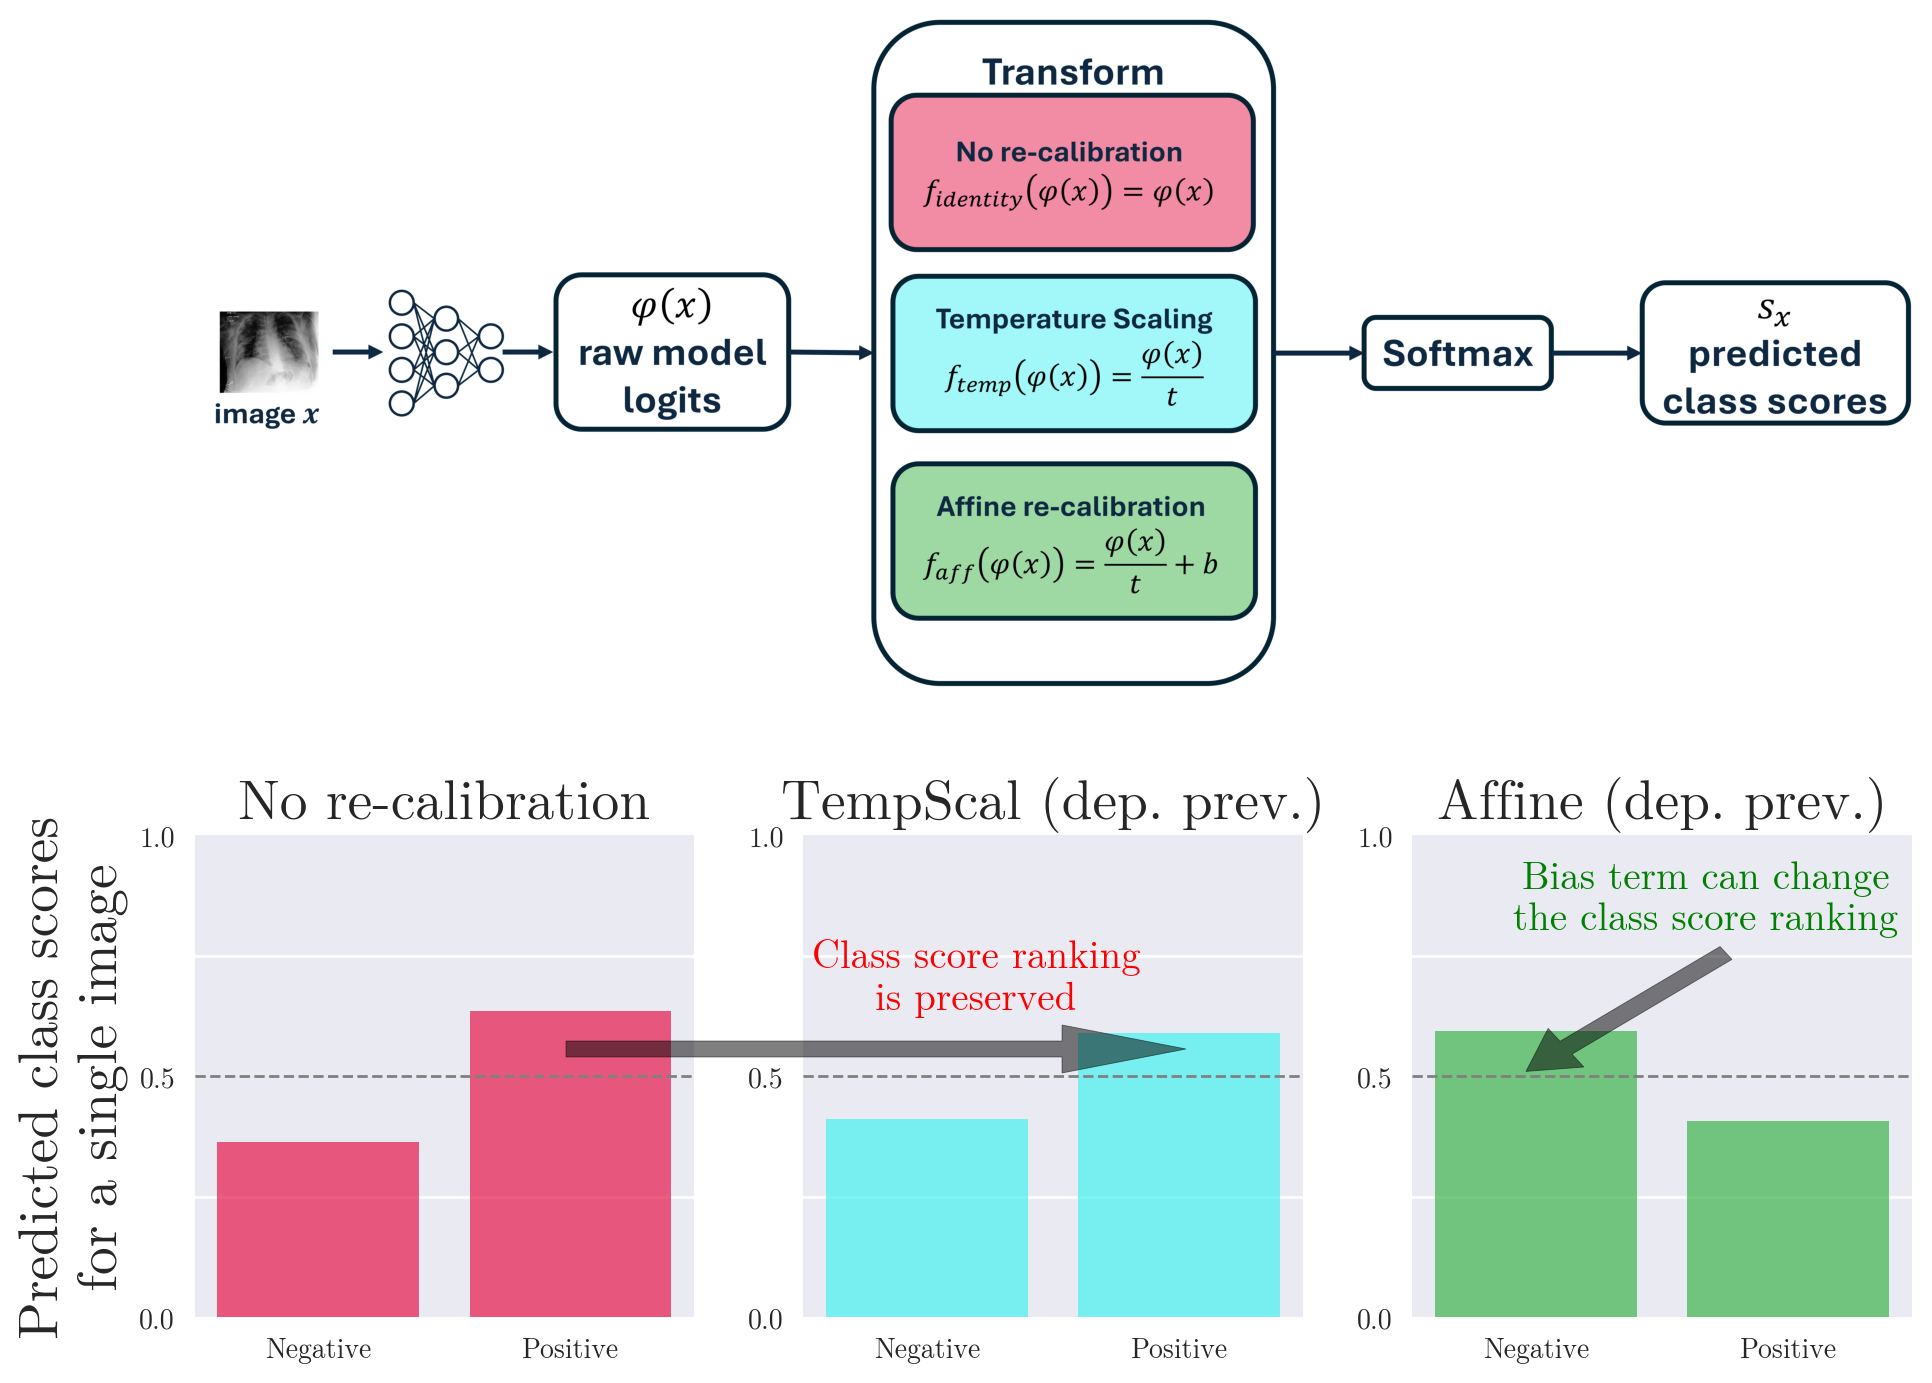

In [16]:
fig = view_logit_visualisation(18, 15)

In [14]:
fig.savefig(RESULT_PATH / "24_fig_3.pdf", format='pdf')

# Generate Figure 7

In [7]:
results = get_all_logits_and_thresholds('mura_xr_elbow', 5, thresholds=True)

In [8]:
def plot_multiple_tasks(tasks: list, ir: int, image: bool = True, logit: bool = False):
    """
    Plots Figure 7 for the given tasks, at the given imbalance ratio

    :param tasks: tasks to be plotted
    :param ir: imbalance ratio
    :param image: whether to plot example images. Defaults to True.
    :param logit: whether to apply log odds transformation. Defaults to False.
    :return the figure
    """
    all_logits = []
    all_classes = []
    all_thresholds = []
    all_titles = []
    img_paths = []
    task_names = []
    task_max_counts = []

    for task_no, task in enumerate(tasks):
        results = get_all_logits_and_thresholds(task, ir, thresholds=True)

        # Append data for each task
        task_logits = [results['original_logits'], results['app_test_logits'], results['affine_logits']]
        all_logits.extend(task_logits)
        all_classes.extend([results['original_labels'], results['app_test_classes'], results['app_test_classes']])
        all_thresholds.extend(
            [results['original_thresholds'], results['app_test_thresholds'], results['affine_thresholds']])

        if task_no == 0:
            all_titles.extend([f'Development\nno re-calibration', f'Deployment\nno re-calibration',
                               'Deployment\nAffine re-calibration'])
        else:
            all_titles.extend(["", "", ""])

        # Append image path and task name
        img_paths.append(
            RESULT_PATH / f'miniatures/miniatures_{task}.png')  #")#(f'path/to/{task}_image.jpg')  # Adjust this path as needed
        task_names.append(task)

        # Calculate max count for this task
        task_max_count = max(np.histogram(logits[:, 0], bins=30)[0].max() for logits in task_logits)
        task_max_counts.append(task_max_count)

    # Create the big plot
    fig = plot_softmax_distributions(
        img_paths=img_paths,
        logits_list=all_logits,
        classes_list=all_classes,
        titles=all_titles,
        thresholds_list=all_thresholds,
        task_names=task_names,
        task_max_counts=task_max_counts,
        image=image,
        logit=logit
    )

    arrow = plt.Arrow(0.48, 0.73, 0.037, 0, width=0.07, color='red')
    fig.add_artist(arrow)
    arrow = plt.Arrow(0.48, 0.27, 0.037, 0, width=0.07, color='red')
    fig.add_artist(arrow)
    return fig


def plot_softmax_distributions(img_paths: list, logits_list: list, classes_list: list,
                               titles: list, thresholds_list: list, task_names: list,
                               task_max_counts: list, image: bool = True, logit: bool = False):
    """
    Plots softmax distributions for multiple example tasks.

    :param img_paths: paths to example task images
    :param logits_list: list of model outputs
    :param classes_list: list of true classes
    :param titles: subplot titles
    :param thresholds_list: decision thresholds
    :param task_names: names of example tasks
    :param task_max_counts: max count to scale the y axis
    :param image: whether to plot example images together with the histograms. Defaults to True.
    :param logit: whether to use log odds. Defaults to False.
    """
    # Define plot column and row numbers
    n_plots = len(logits_list)
    n_rows = len(task_names)
    n_cols = n_plots // n_rows
    if image:
        n_cols += 1

    # Create the figure
    fig = plt.figure(figsize=(20 * n_cols / 3, 6 * n_rows))
    gs = fig.add_gridspec(n_rows, n_cols)

    legend_added = False
    plot_index = 0

    for task_index, (task_name, task_max_count) in enumerate(zip(task_names, task_max_counts)):
        # Image subplot for each task
        if image:
            ax_img = fig.add_subplot(gs[task_index * ((n_plots // len(task_names)) // n_cols + 1), 0])
            img = Image.open(img_paths[task_index])
            ax_img.imshow(img)
            ax_img.axis('off')
            ax_img.text(0.5, -0.1, task_name_map[task_name].replace("<br>", " "), ha='center', va='center',
                        transform=ax_img.transAxes, fontsize=30)

        # Histogram subplots for each task
        for i in range(n_plots // len(task_names)):
            row = task_index
            if image:
                col = (plot_index % (n_cols - 1)) + 1
            else:
                col = plot_index % n_cols

            ax = fig.add_subplot(gs[row, col])
            x_label = "Predicted class score" if not logit else "Log odds"
            y_label = "Predicted class scores\nhistogram" if not logit else "Log odds histogram"
            plot_discrete_histogram(ax, logits_list[plot_index], classes_list[plot_index],
                                    thresholds_list[plot_index], titles[plot_index],
                                    add_legend=(not legend_added), x_label=x_label if row == 1 else "",
                                    y_label=y_label, set_y_label=col == 1, fontsize=30,
                                    logit=logit)
            legend_added = True

            if not logit:
                # Set y-axis limit and add text
                y_limit = task_max_count / 4
                ax.set_ylim(0, y_limit)
                d = .015  # how big to make the diagonal lines in axes coordinates
                kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
                ax.plot((-d, +d), (1 - d, 1 + d), **kwargs)

            plot_index += 1

    # Adjust layout and display the plot
    plt.tight_layout()
    return fig


def plot_discrete_histogram(ax, data: torch.Tensor, labels: torch.Tensor, thresholds: dict,
                            title: str, add_legend: bool = False, metrics: list = [Metric.ACCURACY],
                            x_label: str = 'Class scores', y_label: str = 'Count', fontsize: int = 22,
                            center_legend: bool = False, set_y_label: bool = False, logit: bool = False):
    """
    Plots a histogram of model outputs, grouped by true class, and thresholds for given metrics

    :param ax: subplot
    :param data: model outputs
    :param labels: true labels
    :param thresholds: thresholds for given metrics
    :param title: figure title
    :param add_legend: whether to plot legend. Defaults to False.
    :param metrics: list of metrics for which to plot thresholds. Defaults to [Metric.ACCURACY].
    :param x_label: x axis title. Defaults to 'Class scores'.
    :param y_label: y axis title. Defaults to 'Count'.
    :param fontsize: Defaults to 22.
    :param center_legend: whether to center the legend. Defaults to False.
    :param set_y_label: whether to plot y label. Defaults to False.
    :param logit: plot log odds instead of raw predictions. Defaults to False.
    """
    # define line styles for different metrics
    linestyles = {'argmax': (0, (5, 3)), Metric.ACCURACY: (0, (5, 2)), Metric.F1: (0, (5, 5)), Metric.MCC: (0, (5, 11)),
                  Metric.BALANCED_ACC: (2, (5, 7))}

    # plot histograms for the given classes
    num_classes = data.shape[1]
    for class_idx in range(num_classes):
        softmax_probs = data[labels == class_idx, 0]

        # transform to log odds
        if logit:
            softmax_probs = torch.log(softmax_probs) - torch.log(1 - softmax_probs)

        ax.hist(softmax_probs, bins=30, alpha=0.5, label=f'Class {class_idx}')

    # configure the axes
    ax.set_xlabel(x_label, fontsize=fontsize)
    if not logit: ax.set_xlim(0, 1)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    if set_y_label:
        ax.set_ylabel(y_label, fontsize=fontsize, labelpad=20)

    ax.set_title(title, fontsize=fontsize, fontweight='bold')

    # add IR box
    ax.annotate(f'IR={imbalance_ratio(labels):.1f}', xy=(1, 1), xytext=(-10, -10),
                xycoords='axes fraction', textcoords='offset points',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=1),
                ha='right', va='top', fontsize=fontsize)

    # add threshold lines
    if num_classes == 2:
        lines = []
        line = ax.axvline(x=0.5 if not logit else 0, color='gray', linestyle=linestyles['argmax'], linewidth=3)
        lines.append(line)
        lines.extend(
            [ax.axvline(x=thresholds[metric] if not logit else np.log(thresholds[metric] / (1 - thresholds[metric])),
                        color=[t / 255 for t in get_metric_color(metric)],
                        linestyle=linestyles[metric], linewidth=3) for metric in metrics])
        descriptions = ['Argmax threshold']
        descriptions.extend([metric.value + " optimal threshold" for metric in metrics])

        # add legend
        if add_legend:
            legend = plt.figlegend(lines, descriptions,
                                   loc='lower center',
                                   ncol=len(lines),
                                   bbox_to_anchor=(1 / 4 + 0.5 * (4 - 1) / 4, -0.06) if not center_legend else (
                                   0.5, -0.06),
                                   frameon=False,
                                   fontsize=fontsize)

            # adjust figure size to accommodate legend
            bbox = legend.get_window_extent(ax.figure.canvas.get_renderer())
            bbox_fig = bbox.transformed(ax.figure.transFigure.inverted())
            ax.figure.set_size_inches(ax.figure.get_size_inches()[0], ax.figure.get_size_inches()[1] + bbox_fig.height)

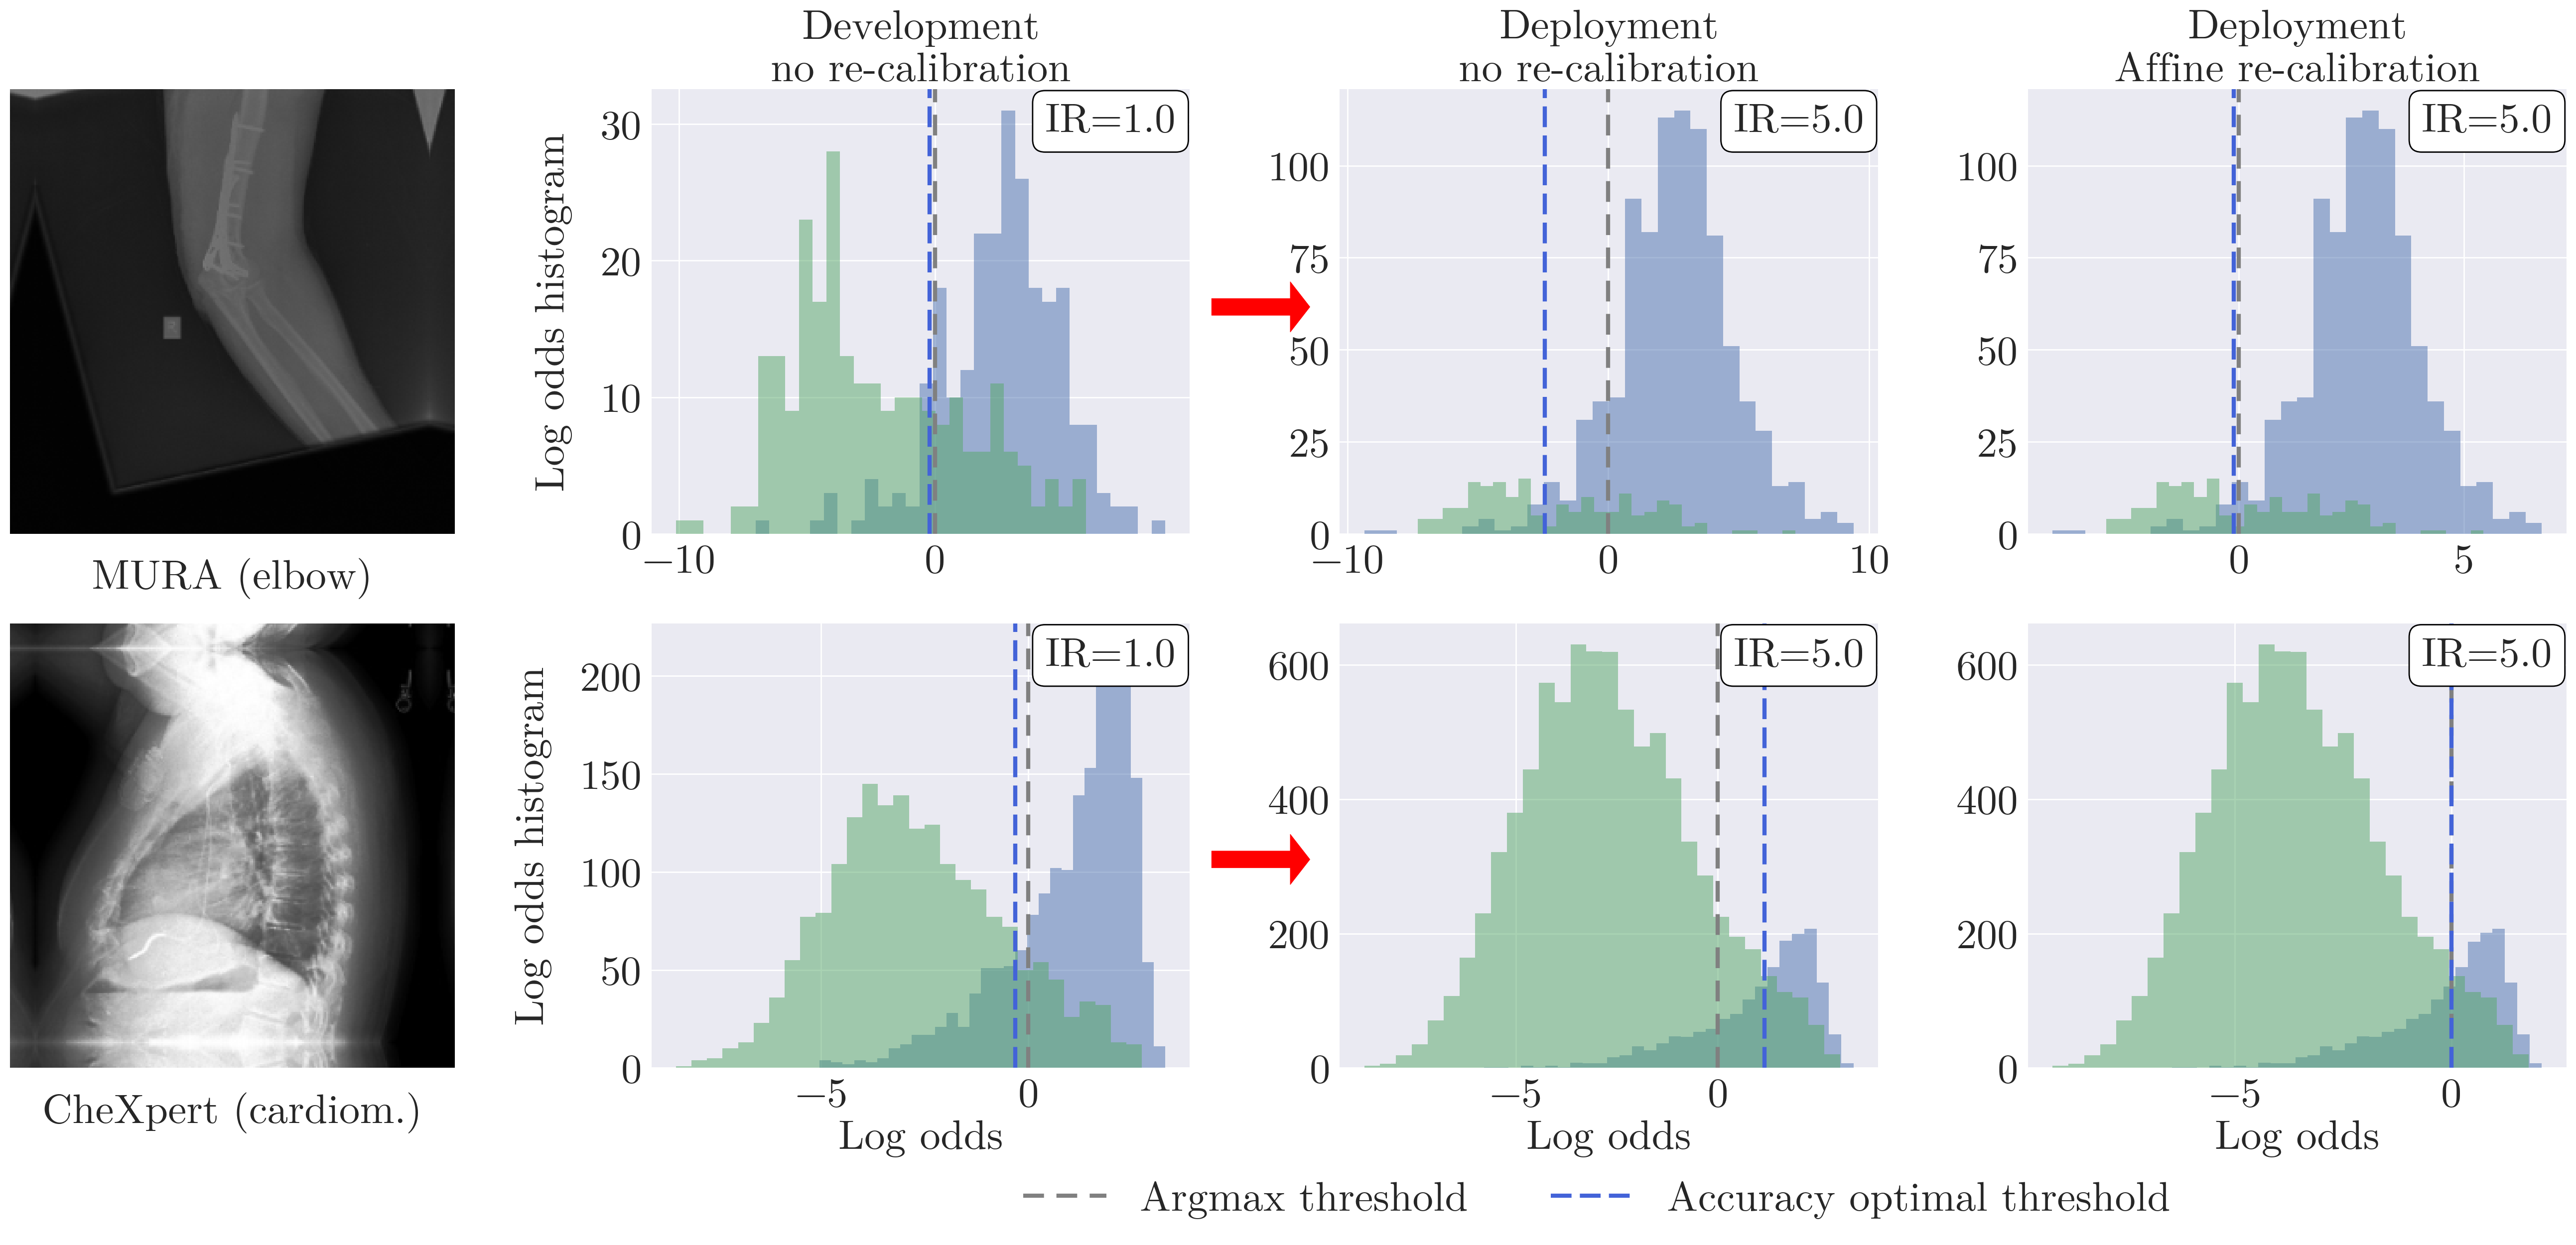

In [10]:
tasks = ['mura_xr_elbow', 'chexpert_cardiomegaly']
ir = 5
fig = plot_multiple_tasks(tasks, ir, image=True, logit=True)

In [21]:
fig.savefig(RESULT_PATH / "24_fig_7.pdf", format='pdf', bbox_inches='tight')

# Generate Figure 8

In [18]:
def plot_task_thresholds(tasks: list, ir: int = 5, fontsize: int = 22, logit: bool = False):
    """
    Generates figure 8, plotting multiple thresholds on histograms of predicted class scores for multiple tasks

    :param tasks: list of tasks
    :param ir: imbalance ratio. Defaults to 5.
    :param fontsize: Defaults to 22.
    :param logit: whether to use log odds transformation. Defaults to False.
    """
    all_logits = []
    all_classes = []
    all_thresholds = []
    all_titles = []
    img_paths = []
    task_names = []
    task_max_counts = []

    # collect task data
    for task in tasks:
        results = get_all_logits_and_thresholds(task, ir, thresholds=True)

        # Append data for each task
        all_logits.append(results['affine_logits'])
        all_classes.append(results['app_test_classes'])
        all_thresholds.append(results['affine_thresholds'])
        all_titles.append('')

        # Append image path and task name
        img_paths.append(RESULT_PATH / f'miniatures/miniatures_{task}.png')
        task_names.append(task)

        # Calculate max count for this task
        task_max_count = np.histogram(results['affine_logits'][:, 0], bins=30)[0].max()
        task_max_counts.append(task_max_count)

    # Create the big plot
    fig = plot_thresholds(
        img_paths=img_paths,
        logits_list=all_logits,
        classes_list=all_classes,
        titles=all_titles,
        thresholds_list=all_thresholds,
        task_names=task_names,
        task_max_counts=task_max_counts,
        fontsize=fontsize,
        logit=logit
    )
    return fig


def plot_thresholds(img_paths: list, logits_list: list, classes_list: list,
                    titles: list, thresholds_list: list, task_names: list,
                    task_max_counts: list, fontsize: int = 22, logit: bool = False):
    """
    Plot example images and thresholds

    :param img_paths: paths to example images
    :param logits_list: list of model outputs
    :param classes_list: list of true classes
    :param titles: titles for histogram subplots
    :param thresholds_list: list of threshold dictionaries
    :param task_names: names of used tasks
    :param task_max_counts: max values to scale the y axis
    :param fontsize: Defaults to 22.
    :param logit: whether to use log odds transformation. Defaults to False.
    """
    # define numbers of rows and columns
    n_plots = len(logits_list)
    n_rows = 2
    n_cols = n_plots

    # Create the figure
    fig = plt.figure(figsize=(20 * n_cols / 3, 6 * n_rows))
    gs = fig.add_gridspec(n_rows, n_cols)

    legend_added = False

    # create subplots for all relevant tasks
    for task_index, (task_name, task_max_count) in enumerate(zip(task_names, task_max_counts)):
        # add image subplot for each task
        ax_img = fig.add_subplot(gs[0, task_index])
        img = Image.open(img_paths[task_index])
        ax_img.imshow(img)
        ax_img.axis('off')
        ax_img.text(0.5, 1.05, task_name_map[task_name].replace("<br>", " "), ha='center', va='center',
                    transform=ax_img.transAxes, fontsize=fontsize)
        if not legend_added:
            ax_img.text(-0.05, 0.5, "Example image", ha='center', va='center', transform=ax_img.transAxes,
                        fontsize=fontsize, rotation=90)

        # add histogram for each task
        ax = fig.add_subplot(gs[1, task_index])
        plot_discrete_histogram(ax, logits_list[task_index], classes_list[task_index],
                                thresholds_list[task_index], titles[task_index],
                                add_legend=(not legend_added),
                                metrics=[Metric.ACCURACY, Metric.F1, Metric.MCC, Metric.BALANCED_ACC],
                                x_label="Predicted class score" if not logit else "Logit value",
                                y_label="Predicted class scores\nhistogram" if not logit else "Logits histogram",
                                center_legend=True,
                                fontsize=fontsize, set_y_label=(not legend_added), logit=logit)

        legend_added = True

        if not logit:
            # Set y-axis limit and add text
            y_limit = task_max_count / 4
            ax.set_ylim(0, y_limit)
            d = .015  # how big to make the diagonal lines in axes coordinates
            kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
            ax.plot((-d, +d), (1 - d, 1 + d), **kwargs)

    # Adjust layout and display the plot
    plt.tight_layout()
    return fig

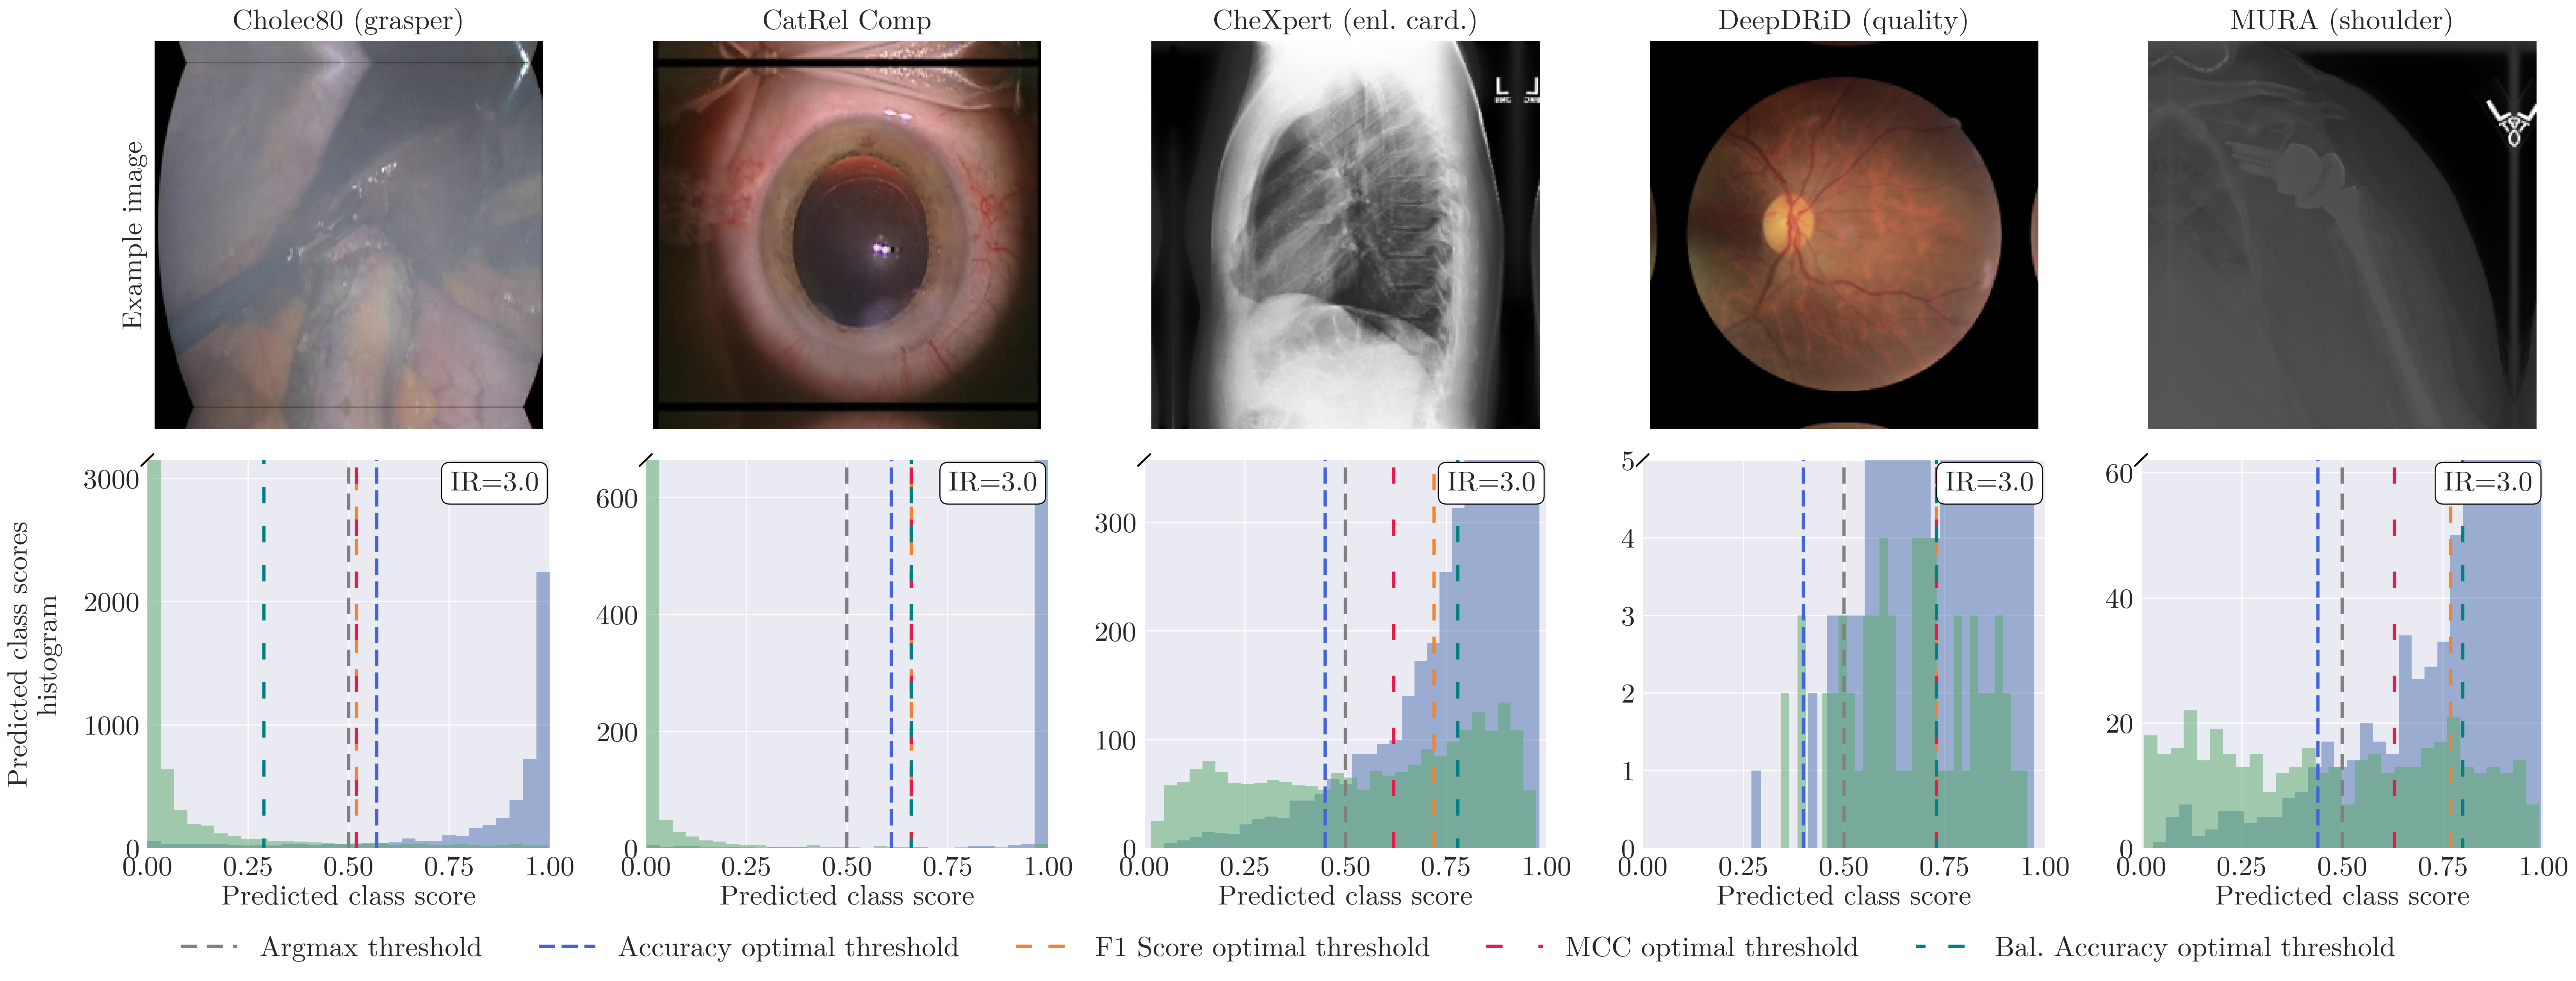

In [19]:
# plot Figure 8
five_tasks = ['cholec80_grasper_presence', 'idle_action_recognition', 'chexpert_enlarged_cardiomediastinum',
              'deep_drid_quality', 'mura_xr_shoulder']
fig = plot_task_thresholds(five_tasks, ir=3, fontsize=26, logit=False)

In [20]:
fig.savefig(RESULT_PATH / "24_fig_8.pdf", format='pdf', bbox_inches='tight')